In [1]:
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from scipy.misc import comb
import pandas as pd
import numpy as np
import trimesh
import glob
import math
import re

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def distance3D(a, b):
    return math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2+(a[2]-b[2])**2)

def distance2D(a, b):
        return math.sqrt( ((b[0]-a[0])**2)  + ((b[1]-a[1])**2) )
    
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

def lin_refine_implicit(x, n):
    """
    Given a 2D ndarray (npt, m) of npt coordinates in m dimension, insert 2**(n-1) additional points on each trajectory segment
    Returns an (npt*2**(n-1), m) ndarray
    """
    if n > 1:
        m = 0.5*(x[:-1] + x[1:])
        if x.ndim == 2:
            msize = (x.shape[0] + m.shape[0], x.shape[1])
        else:
            raise NotImplementedError

        x_new = np.empty(msize, dtype=x.dtype)
        x_new[0::2] = x
        x_new[1::2] = m
        return lin_refine_implicit(x_new, n-1)
    elif n == 1:
        return x
    else:
        raise ValueError

def vertex_correspondece(mesh, p_3D):
    distances = []
    for v in mesh.vertices:
        distances.append(distance3D(p_3D, v))
    distances = np.array(distances)
    return mesh.vertices[distances.argmin()]

In [4]:
torsos = glob.glob("/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/*.obj")
indi_values = []
values = []
temp_vertex = []
for t in torsos:
    print(t)
    mesh = trimesh.load(t)
    landmarks_f = t.replace(".obj", ".pts")
    landmarks_f = landmarks_f.replace("modelos_artificiales", "landmarks_artificiales")
    landmarks = pd.read_csv(landmarks_f, header=None, index_col=[0], skiprows=range(2), delimiter=r"\s+")
    ls0 = landmarks.iloc[0].tolist()
    ls1 = landmarks.iloc[4].tolist()
    ls2 = landmarks.iloc[9].tolist()
    ls3 = landmarks.iloc[10].tolist()
    l_inferior = vertex_correspondece(mesh, np.array([ls1,ls2]).mean(0))
    l_superior = vertex_correspondece(mesh, np.array([ls0,ls3]).mean(0))
    dist_l = distance2D(l_inferior, l_superior)
    matrix_translate = [[1, 0, 0, 0],[0, 1, 0, dist_l / 100], [0, 0, 1, 0],[0, 0, 0, 1]]
    points = [None] * 100
    p = l_inferior
    for i in range(100):
        p = np.dot(matrix_translate, [p[0], p[1], p[2], 1])[:-1] 
        points[i] = vertex_correspondece(mesh, p)
        #sections[i] = mesh.section(plane_origin = vertex_correspondece(mesh, p) ,plane_normal = [0,1,0])    
    points = np.array(points)
    points = np.flip(points, axis=0)
    xvals, yvals = bezier_curve(points[:, [1, 2]], nTimes=500)
    sections = [None] * 250
    values = []
    temp_vertex = []
    for i in range(250):
        sections[i] = mesh.section(plane_origin = [l_inferior[0], xvals[i] , yvals[i]] ,plane_normal = [0,1,0])
        section_2D = sections[i].vertices[:,[0,2]]
        #section_2D, to_3D = sections[i].to_planar()
        vertexs_2d = section_2D
        mx = np.mean(vertexs_2d[:,0])
        my = np.mean(vertexs_2d[:,1])
        vertexs_2d = np.array(sorted(vertexs_2d, key=lambda x : (math.atan2(x[0] - mx, x[1] - my) + 2 * math.pi) % (2*math.pi)))
        xy = np.vstack((vertexs_2d[:,0], vertexs_2d[:,1])).T
        xy_highres_lin = lin_refine_implicit(xy, n=3)
        n=2712
        xy= xy.flatten()
        xy_highres_lin= xy_highres_lin.flatten()
        zro = np.zeros(n)
        zro[:xy.shape[0]] = xy
        zro = zro.reshape((zro.shape[0]//2),2)
        xy_highres_lin = xy_highres_lin.reshape((xy_highres_lin.shape[0]//2,2))
        zro[xy.shape[0]//2:n//2] = xy_highres_lin[np.random.randint(xy_highres_lin.shape[0],size=abs(n//2 - xy.shape[0]//2))]
        mx = np.mean(zro[:,0])
        my = np.mean(zro[:,1])
        vertexs_2d = np.array(sorted(zro, key=lambda x : (math.atan2(x[0] - mx, x[1] - my) + 2 * math.pi) % (2*math.pi)))
        temp_vertex.append(vertexs_2d)
        values.append(np.array(vertexs_2d).flatten())
    indi_values.append(np.array(values).flatten())
    #plt.axes().set_aspect('equal', 'datalim')
    #plt.plot(xvals, yvals,".")
    #plt.plot(sections[:, 1], sections[:, 2], ".")
    

/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_362_M.obj


/home/pablo/.miniconda3/envs/fetas_3D/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  if sys.path[0] == '':


/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_333_M.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_299_M.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_213_F.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_246_M.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_339_M.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_63_F.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_133_F.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_310_M.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_175_F.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_195_F.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_337_M.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_203_F.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artificiales/model_180_F.obj
/home/pablo/Dataset/dataset3D_CITES/modelos_artifici

In [13]:
del temp_vertex, values

In [20]:
indi_values = np.array(indi_values)
#np.save("test", indi_values)

MemoryError: 

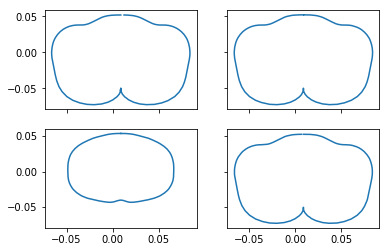

In [10]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(temp_vertex[0][:,0],temp_vertex[0][:,1],"-")

ax2.plot(temp_vertex[1][:,0],temp_vertex[1][:,1],"-")

ax3.plot(temp_vertex[-1][:,0],temp_vertex[-1][:,1],"-")

ax4.plot(temp_vertex[3][:,0],temp_vertex[3][:,1],"-")

plt.show()

In [15]:
from scipy.spatial import procrustes

In [16]:
indi_values = np.array(indi_values)
indi_values = indi_values.reshape(-1,indi_values.shape[1]//2,2)
pcentro = indi_values.mean(0)
procrusteados = []
for p1 in indi_values:
    mtx1,mtx2, disparity = procrustes(pcentro,p1)
    procrusteados.append(mtx2)


AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
np.shape(procrusteados)

In [ ]:
np.shape(procrusteados)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(procrusteados[0][:,0],procrusteados[0][:,1],"-")
#ax1.set_title("id="+ids[0])
ax2.plot(procrusteados[5][:,0],procrusteados[5][:,1],"-")
#ax2.set_title("id="+ids[5])
ax3.plot(procrusteados[6][:,0],procrusteados[6][:,1],"-")
#ax3.set_title("id="+ids[6])
ax4.plot(procrusteados[-1][:,0],procrusteados[-1][:,1],"-")
#ax4.set_title("id="+ids[-1])

In [ ]:
np.save("procrustes_mujeres_artificiales", procrusteados)

In [ ]:
np.save("procrustes_files_mujeres_artificiales", torsos)

In [ ]:
#np.save("procrustes_id_mujeres_artificiales", list(map(lambda x: re.findall(r'\d+', x)[1], torsos)))